# **Whisper AI on Kubeflow - An Introduction**

#### The notebook provides background and four demonstrations of the Whisper AI Automated Speech Recognition (ASR) models running on Kubeflow.

## *Why Whisper*
#### For language transcription and translation, Whisper models approach the accuracy and robustness of humans.

## Whisper Description
- The Whisper open source architecture is a simple end-to-end approach, implemented as an encoder-decoder Transformer.  
- Input audio is split into 30-second chunks, converted into a log-Mel spectrogram, and then passed into an encoder. 
- A decoder is trained to predict the corresponding text caption, intermixed with special tokens that direct the single model to perform tasks such as language identification, phrase-level timestamps, multilingual speech transcription, and to-English speech translation. https://openai.com/blog/whisper/


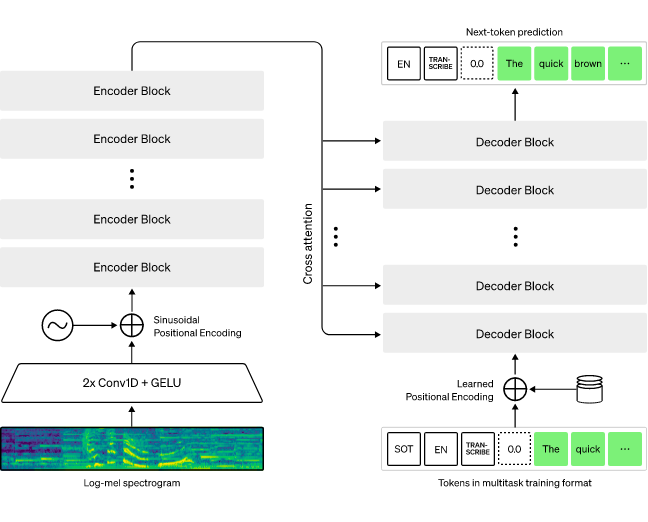

# Whisper's Performance & Benchmarking 

- When scaled to 680,000 hours of multilingual and multitask supervision, the resulting models generalize well to standard benchmarks.  (reference human life of 80 years = 692,040 hours)
- The models are often competitive with prior fully supervised results but in a zeroshot = transfer setting without the need for any finetuning. 
- When compared to humans, the models approach their accuracy and robustness.

The importance of larger data sets for Robust Speech Recognition via Large-Scale Weak Supervision (info from https://cdn.openai.com/papers/whisper.pdf)
- There is still only a moderate amount of supervised data easily available. i.e. SpeechStew(Chan et al., 2021) mixes together 7 pre-existing datasets totalling 5,140 hours of supervision
- By relaxing the requirement of gold standard human-validated transcripts, Chen et al. (2021) and Galvez et al. (2021) make use of sophisticated automated pipelines to scale weakly supervised speech recognition to 10,000 and 30,000 hours of noisier training data. 
- This trade-off between quality and quantity is often the right call.
- Whisper scaled weakly supervised speech recognition to the next order of magnitude i.e. 680,000 hours of labeled audio data (note - the data set was not open sourced)

### Comparing (open source) Whisper to (commercial) ASR models - https://cdn.openai.com/papers/whisper.pdf

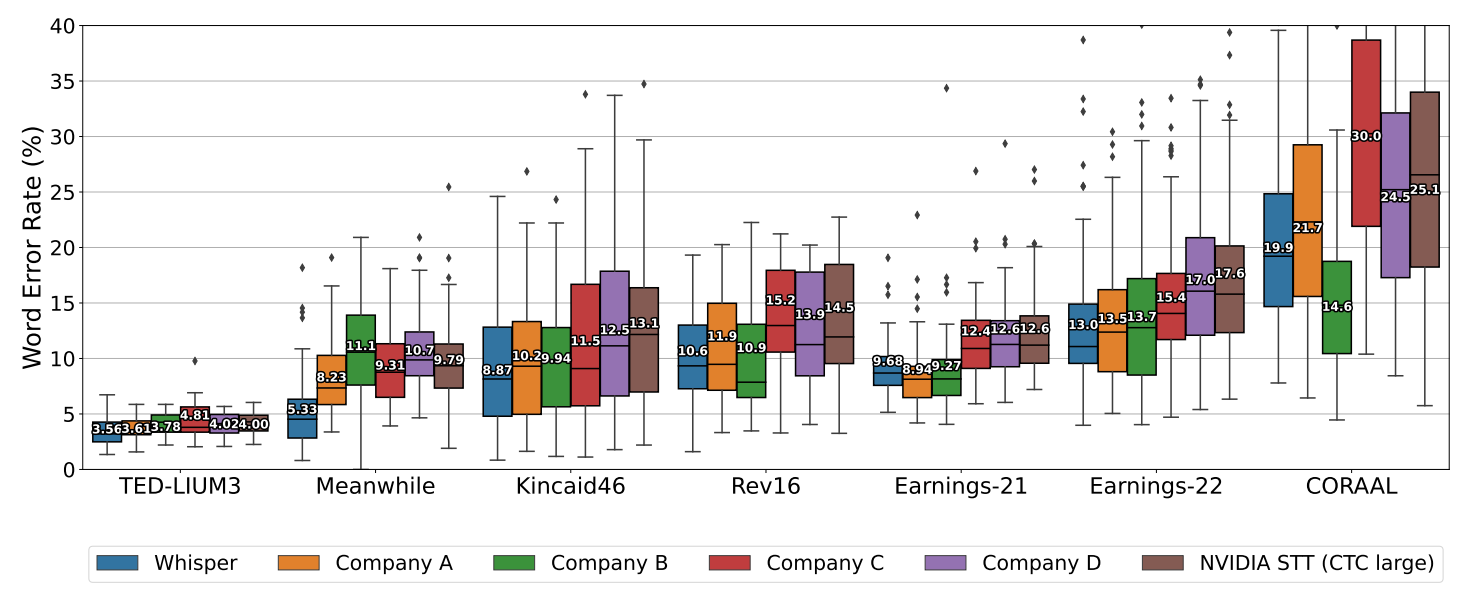

Figure 6. Whisper is competitive with state-of-the-art commercial and open-source ASR systems in long-form transcription. The
distribution of word error rates from six ASR systems on seven long-form datasets are compared, where the input lengths range from a
few minutes to a few hours. The boxes show the quartiles of per-example WERs, and the per-dataset aggregate WERs are annotated
on each box. Our model outperforms the best open source model (NVIDIA STT) on all datasets, and in most cases, commercial ASR
systems as well.

## Whisper's Word Error Rate

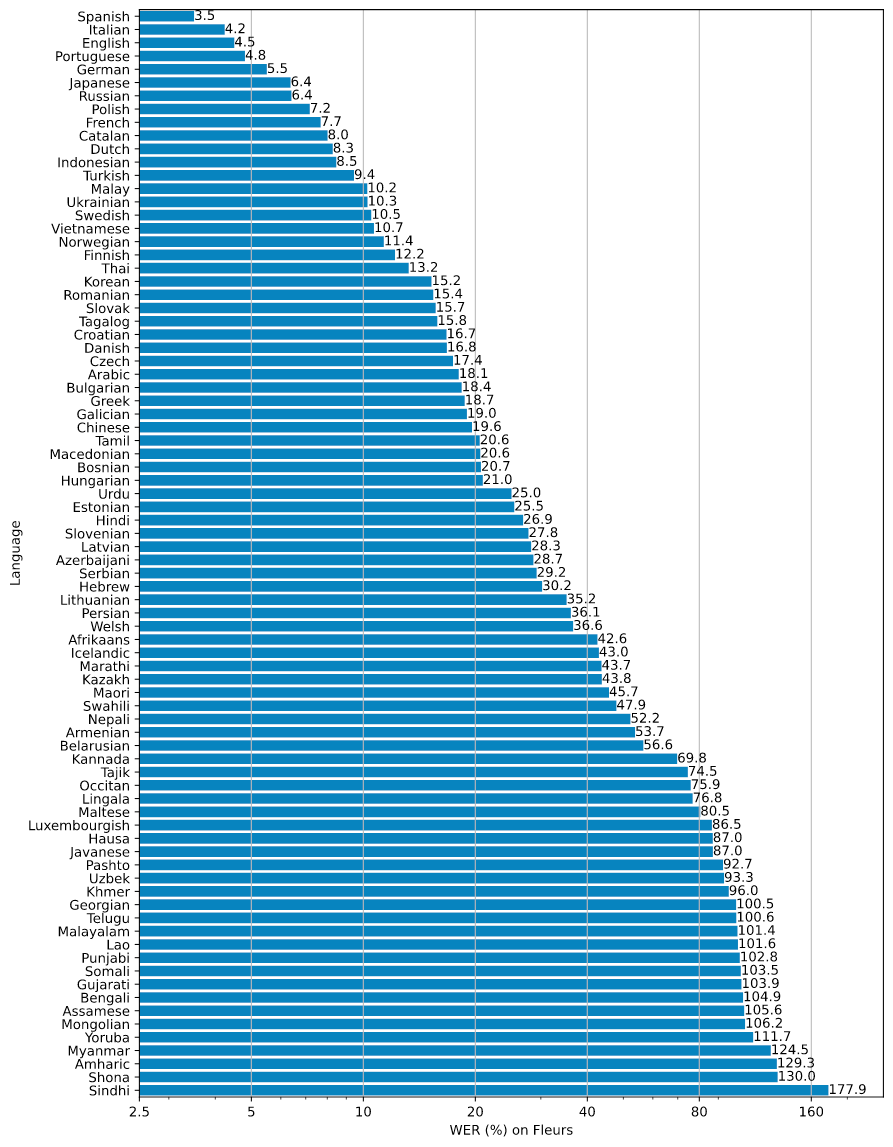

# Installation

### Kubeflow configuration (CPU based)

Configure a jupyter notebook with 2 CPUs, 5 GB RAM and 25 GB disk.  This example is running on Arrikto's MiniKF, which is easy to set-up for testing.  This link provides instructions for MiniKF on GCP, https://console.cloud.google.com/marketplace/product/arrikto-public/minikf?project=minikf-258916

### Whisper requires: 
1) Python3.7+ 
2) a recent version of PyTorch (the Whisper AI team used PyTorch 1.12.1 without issue)  
3) FFmpeg, an audio-processing library
4) Rust

#### Install whisper and force upgrades

In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/openai/whisper.git -q 

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --no-deps --force-reinstall git+https://github.com/openai/whisper.git -q

#### Install ffmpeg

#### (Important - via Terminal on Jupyter server) 
1. sudo apt update

1. sudo apt install ffmpeg -y

#### Install Rust dependencies

In [ ]:
import sys
!{sys.executable} -m pip install setuptools-rust -q

# Fetch an audio file for testing

The audio file for the following demonstrations is from Dark Knight Rises extracted from Moviessoundclips.net and has the following transcription:

*“Oh, you think darkness is your ally. But you merely adopted the dark. I was born in it, molded by it. I didn’t see the light until I was already a man, by then it was nothing to me but blinding!”*

In [ ]:
!wget -O audio.mp3 http://www.moviesoundclips.net/movies1/darkknightrises/darkness.mp3

# Whisper provides different model sizes

The Whisper model has different sizes, which provide different performance, especially with repect to accuracy and speed.

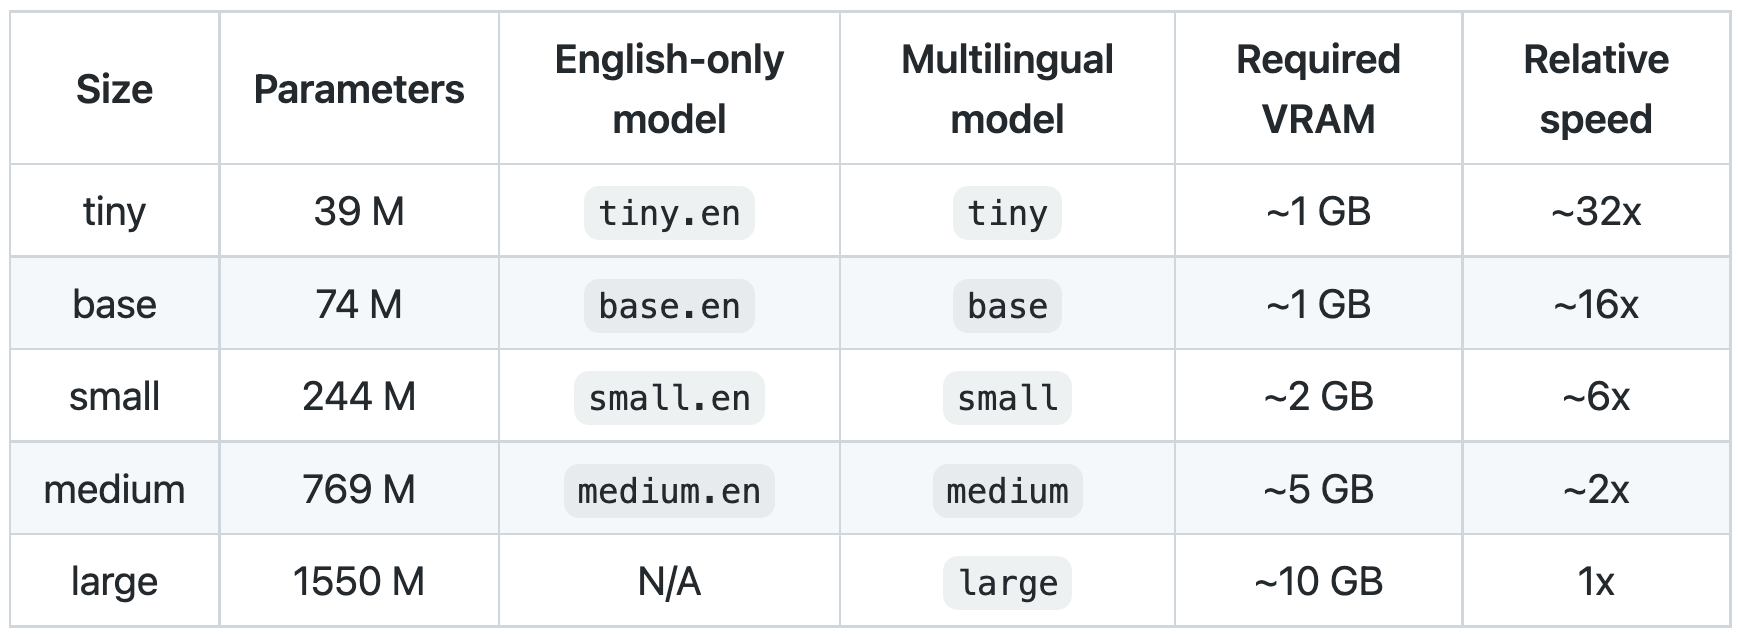 

# Demo 1 - Transcription with Base model

In [ ]:
import whisper

In [ ]:
model = whisper.load_model("base")

In [ ]:
result = model.transcribe("audio.mp3")

In [ ]:
print(result["text"])

“Oh, you think darkness is your ally. But you merely adopted the dark. I was born in it, molded by it. I didn’t see the light until I was already a man, by then it was nothing to me but blinding!” - Actual

# Demo 2 - Transcription with Medium model

In [ ]:
audio = whisper.load_audio("audio.mp3")

In [ ]:
medium_model = whisper.load_model("medium")

In [ ]:
result = medium_model.transcribe("audio.mp3")

In [ ]:
print(result["text"])

“Oh, you think darkness is your ally. But you merely adopted the dark. I was born in it, molded by it. I didn’t see the light until I was already a man, by then it was nothing to me but blinding!” - Actual

## Demo 3 - Low level transcription demo and details

Internally, the transcribe() method reads the entire file and processes the audio with a sliding 30-second window, performing autoregressive sequence-to-sequence predictions on each window.

Below is an example usage of whisper.detect_language() and whisper.decode() which provide lower-level access to the model.   This example is from: https://github.com/openai/whisper

In [ ]:
import whisper

In [ ]:
model = whisper.load_model("base")

In [ ]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("audio.mp3")
audio = whisper.pad_or_trim(audio)

In [ ]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

In [ ]:
# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

In [ ]:
# decode the audio...note if you are using CPU, set fp16=False
options = whisper.DecodingOptions(fp16=False)

In [ ]:
result = whisper.decode(model, mel, options)

In [ ]:
# print the recognized text
print(result.text)

## Demo 4 - Transcription demonstration with web app and your microphone 
from Franco Vega's medium article: https://medium.com/@franco.vegam/how-to-run-whisper-speech-recognition-model-and-create-a-simple-app-8426890299d8

Gradio is class that wraps a python function in a user interface.   In this example, the pyton function (interfence), input (microphone), output (textbox)

In [ ]:
import sys
!{sys.executable} -m pip install gradio -q

In [ ]:
import gradio as gr 

In [ ]:
def interfence(audio):
    time.sleep(3)
    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(base_model.device)
    
    options = whisper.DecodingOptions(without_timestamps=True)
    result = whisper.decode(base_model, model, options)
    return result.text

In [ ]:
gr.Interface(
    title = 'Whisper-app',
    fn = model.transcribe,
    inputs=[
        gr.inputs.Audio(source="microphone", type="filepath")
        ],
        outputs=[
            "textbox"
        ],
        live=True).launch(share=True)